In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cp /content/drive/MyDrive/100k.zip /content/100k.zip
# !unzip -q 100k.zip


Mounted at /content/drive


## 0. Import dependecies

In [ ]:
import random
import numpy as np


from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import seaborn as sb

from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


## 1. Data preprocessing

### Define Dataset class with its methods

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_pairs = []
        self.labels = []

        # Navigate through the folders and collect image pairs
        for subdir in ['0', '1']:
            class_folder = self.root_dir / subdir
            for subfolder in class_folder.iterdir():
                image_files = list(subfolder.glob('*'))  # Collect all image files in the subfolder
                if len(image_files) == 2:  # Ensure there are exactly two images
                    self.image_pairs.append((image_files[0], image_files[1]))
                    self.labels.append(int(subdir))  # Label based on the parent folder

    def __getitem__(self, index):
        img1_path, img2_path = self.image_pairs[index]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(self.labels[index], dtype=torch.float32)

    def __len__(self):
        return len(self.image_pairs)

    def generate_pairs_and_labels(self):
        """ Generator that yields image pairs and their corresponding labels from the dataset. """
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            yield (img1_path, img2_path), label

    def random_sample_info(self, seed=33):
        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)

        idx = random.randint(0, len(self.image_pairs) - 1)
        img1_path, img2_path = self.image_pairs[idx]
        label = self.labels[idx]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        print(f'Label: {label}')
        print(f'Image 1 - Path: {img1_path}, Shape: {img1.shape}, Mean: {img1.mean().item():.2f}, Std: {img1.std().item():.2f}')
        print(f'Image 2 - Path: {img2_path}, Shape: {img2.shape}, Mean: {img2.mean().item():.2f}, Std: {img2.std().item():.2f}')

    def generate_all_pairs(self):
        all_pairs = []
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            all_pairs.append({'image1': img1_path, 'image2': img2_path, 'label': label})
        return all_pairs

    def print_all(self):
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            print(img1_path, img2_path, label)

    def plot_random_image_pair(self, seed=42):
        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)

        # Select a random index and use __getitem__ to fetch the images
        idx = random.randint(0, len(self) - 1)
        img1, img2, label = self[idx]

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        if img1.shape[0] == 1:
            img1 = img1.squeeze(0).numpy()
            img2 = img2.squeeze(0).numpy()
            axs[0].imshow(img1, cmap='gray')
            axs[1].imshow(img2, cmap='gray')
        else:
            img1 = img1.permute(1, 2, 0).numpy()
            img2 = img2.permute(1, 2, 0).numpy()
            img1 = (img1 - img1.min()) / (img1.max() - img1.min())
            img2 = (img2 - img2.min()) / (img2.max() - img2.min())
            axs[0].imshow(img1)
            axs[1].imshow(img2)


        axs[0].set_title('Image 1')
        axs[0].axis('off')


        axs[1].set_title('Image 2')
        axs[1].axis('off')

        plt.suptitle(f'Label: {label.item()}')
        plt.show()


### Create transformator and class instance

In [ ]:
weights = models.ResNet18_Weights.DEFAULT
transform_for_resnet = weights.transforms()

# Dataset & DataLoader
root_dir = "./data"
dataset = SiameseNetworkDataset(root_dir=root_dir, transform=transform_for_resnet)

## 2. Data split

In [ ]:
seed = 777
torch.manual_seed(seed)

# Split dataset into train (70%), valid (15%), and test (15%) sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# Check number of samples in each DataLoader
# print(f'Number of training samples: {len(train_loader.dataset)}')
# print(f'Number of validation samples: {len(valid_loader.dataset)}')
# print(f'Number of test samples: {len(test_loader.dataset)}')

# # Check a few labels from each DataLoader
# def check_labels(loader, name):
#     print(f'\n{name} labels:')
#     for batch in loader:
#         _, _, labels = batch
#         print(labels)
#         break  # Only print the first batch

# check_labels(train_loader, "Train")
# check_labels(valid_loader, "Validation")
# check_labels(test_loader, "Test")

## 3. Model

#### RESNET18

In [ ]:

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()


        weights = models.ResNet18_Weights.DEFAULT
        self.resnet = models.resnet18(weights=weights)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()


        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(num_ftrs, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        x = self.resnet(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        abs_diff = torch.abs(output1 - output2)
        similarity_score = self.fc2(abs_diff)
        return similarity_score

#### Dummy for shapes

In [ ]:
# Instantiate the model
model = ResNet()

# Create a dummy input tensor with the same dimensions as your actual input (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, 124, 124)

# Pass the dummy input through the network and print the output size at each stage
def print_layer_shapes(model, dummy_input):
    x = dummy_input
    for layer in model.cnn1:
        x = layer(x)
        print(f'After layer {layer.__class__.__name__}: {x.shape}')
    x = x.view(x.size()[0], -1)
    print(f'Flattened size: {x.shape}')

# print_layer_shapes(model, dummy_input)

## 4. Init and train the model



### Init model

In [ ]:
# Check if GPU is available
model = ResNet().to(device)

### Init parameters

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
criterion = nn.BCELoss()

# Lists to store losses
train_losses = []
val_losses = []

# Early stopping variables
patience = 7  # Early stopping patience
best_val_loss = np.inf
patience_counter = 0

### Train model

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False) as pbar:
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # # Forward pass
            # output1, output2 = model(img1, img2)

            # # Compute loss
            # loss = criterion(output1, output2, label)

            # Forward pass
            similarity_score = model(img1, img2)
            # Compute loss
            loss = criterion(similarity_score, label.unsqueeze(1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            pbar.set_postfix({'train_loss': running_train_loss / (pbar.n + 1)})
            pbar.update(1)

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.inference_mode():
        for img1, img2, label in valid_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            # output1, output2 = model(img1, img2)
            # loss = criterion(output1, output2, label)
            similarity_score = model(img1, img2)
            loss = criterion(similarity_score, label.unsqueeze(1))
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(valid_loader)
    val_losses.append(val_loss)

    print(f'\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Patience exceeded - early stopping triggered")
        break

    scheduler.step()

print('Training complete.')


Epoch [1/10], Train Loss: 0.5707, Val Loss: 0.5229



Epoch [2/10], Train Loss: 0.4460, Val Loss: 0.5309



Epoch [3/10], Train Loss: 0.3466, Val Loss: 0.6072



Epoch [4/10], Train Loss: 0.2558, Val Loss: 0.6885



Epoch [5/10], Train Loss: 0.1288, Val Loss: 0.6190



Epoch [6/10], Train Loss: 0.0933, Val Loss: 0.6391



Epoch [7/10], Train Loss: 0.0724, Val Loss: 0.6526


KeyboardInterrupt: 

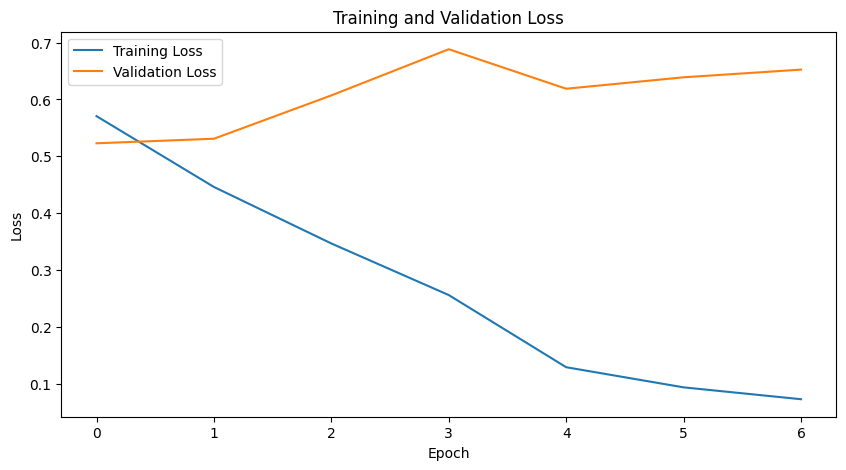

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 5. Test and show metrics

### Test model

In [ ]:
# Testing loop
def test(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.inference_mode():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            similarity_score = model(img1, img2)
            preds = (similarity_score > 0.6).float()  # Threshold at 0.5

            all_labels.extend(label.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert to numpy arrays for evaluation
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute basic metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Similar', 'Similar'], yticklabels=['Not Similar', 'Similar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

Accuracy: 0.7477
Precision: 0.7591
Recall: 0.7276
F1 Score: 0.7430


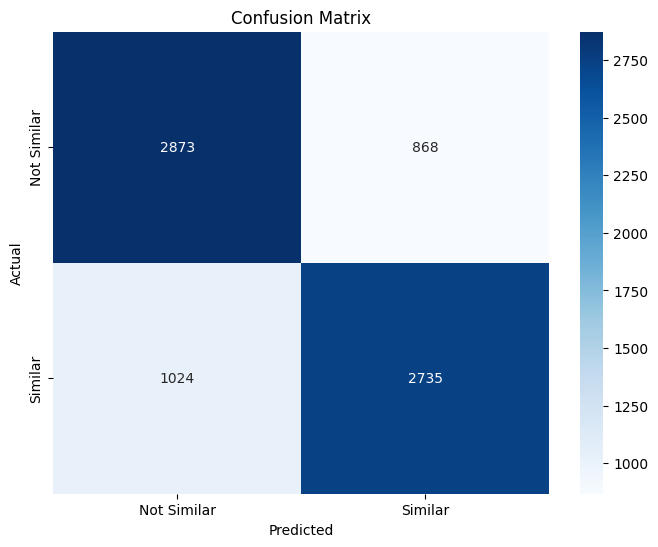

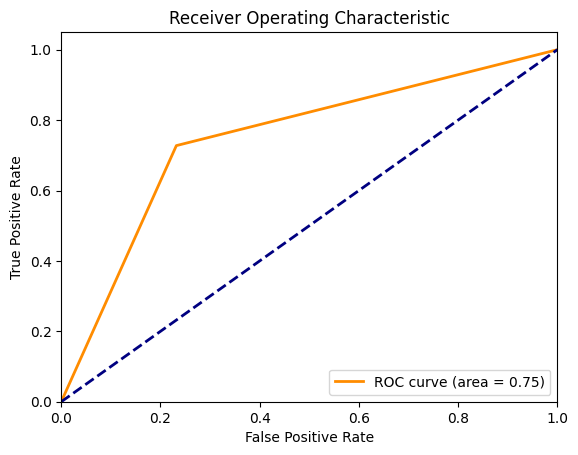

In [ ]:
test(model, test_loader, device)